# LSMLSDA Programming Exercise Week 1
## Modelling decision making with a drift-diffusion model

This exercise was kindly provided by Prof. Sprekeler, Modelling of Cognitive Processes Group, BCCN Berlin. 


We will explore the reaction time distribution of the drift diffusion model
for perceptual decision making. 

Important paper: https://www.ncbi.nlm.nih.gov/pubmed/17600525

General information: https://en.wikipedia.org/wiki/Two-alternative_forced_choice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

### Part 1
Our goal is to simulate a decision making process. A very much simplified approach to that is to simulate a biased random walk: We simulate an internal decision variable, e.g., some neural activity, using a single scalar variable. At every time step, the variable evolves in a certain direction due to sensory evidence for a decision in that direction (drift, $\mu$), plus noise (diffusion, $\sigma$). Such a model is often called a drift-diffusion model. A simple form of the drift diffusion model is given by

$$
dX = \mu \mathrm{dt} + \sigma \mathrm{dW} ,
$$

To simulate the decision making process as a drift-diffusion process we have to integrate this equation. Because it is a stochastic differential equation (sde) we cant use standard implementation like scipy odeint for integration. Therefore, your first task is to implement your own Euler-Marayuma sde solver.

Euler-Maruyama is an extension of the simple Euler method to stochastic differential equations where we here only consider Gaussian noise processes. Euler-Maruyama
integrates differential equations of the form

\begin{align}
dX(t) &= f(X(t))\mathrm{dt} + g(X(t))\mathrm{dW}(t))
\end{align}

here f (X(t)) is the deterministic part of the differential equation and g(X(t))dW (t) is
the stochastic part where dW (t) is a random variable. Euler-Maruyama consists of the
following update which your function has to implement:

\begin{align}
X_t = X_{t-1} + f(X_{t-1}) \Delta t + g(X_{t-1}) \sqrt{\Delta t} W_t
\end{align}

Each $W_t$ is a sample from a standard normal distribution. For more information about
Euler-Maruyama see Higham (2001), or Wikipedia.
Write a function euler_maruyama(ffun, gfun, x0, t, \**args) which implements this equation
and which behaves like scipy odeint. Note that we have defined args as a dictionary which differs
from scipy odeint where args is a tuple. This makes it easier to change individual parameters of
the model functions later.

Start with $X = 0$. Choose
$\sigma = 0.5, \mu = 0.2$. Run five simulations of 10 seconds length with $dt = 0.01s$ and
plot the results.

**Hint**: A single simulation is a trace of values starting at X=0 and evolving as a random walk with a drift towards more positive (or negative) values. Plot all five traces in a single plot with different colors. 

In [2]:
def euler_maruyama(ffun, gfun, x0, t, **kwargs) :
    """ This function implements the Euler Maruyama method. It is basically implementing
    forward Euler on a system of differential equations in which we have an stochastic
    term (SDE).
    """
    
    dt = t[1];
    x0 = np.array(x0); #convert the list of initial values into a numpy array
    sol = np.zeros((np.size(x0),np.size(t))); #create a 2-dim array for the solution.

    for t_ in range(np.size(t)):
        sol[:,t_] = x0 + np.array(ffun(x0, t, **kwargs))*dt + np.array(gfun(x0,**kwargs))*np.sqrt(dt)*np.random.normal(size=x0.shape)
        x0 = sol[:,t_];
        #with this for loop I am filling the 2D-array with the forward euler appropriate values and stochastic term
        #the stochastic term is just a random value with zero variance at each time.
    return sol

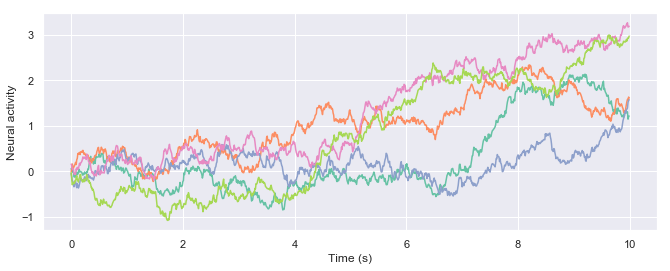

In [3]:
x0 = 0; dt = 0.01
t = np.arange(0,10,dt) 

mu = lambda x0,t,**args: 0.2 #deterministic function
sigma = lambda x0,**args: 0.5 #random function

plt.figure(figsize=(11,4))
sns.set(style="darkgrid"); colors = sns.color_palette("Set2", 5)
#sns.set(style="ticks"); colors = sns.color_palette("rocket_r",5);
[plt.plot(t, euler_maruyama(mu,sigma,x0,t)[0], color=colors[i]) for i in range(5)];
plt.xlabel('Time (s)');plt.ylabel('Neural activity');


### Part 2

Plot the percentage of ”up” (X=+a) responses as a function of the drift μ by
simulating 200 trials for a = 1 and the following $\mu$ values: −0.1, 0, 0.1, 0.2, 0.5.

Resimulate trials in which no decision boundary is reached during the simulation.

Plot the results. What happens to this curve if you double, what if you halve the
value of a?


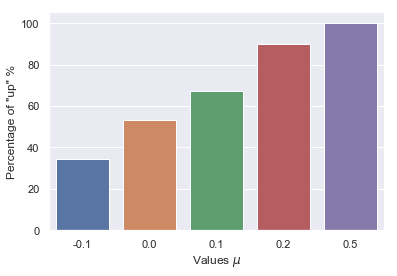

In [4]:
x0 = 0; dt = 0.01
t = np.arange(0,10,dt) 
boundary = 1

values = [-.1, 0, .1, .2, .5]
perc = np.zeros(5)

mu = lambda x0,t,**args: val #deterministic function
sigma = lambda x0,**args: 0.5 #random function

for idx,val in enumerate(values):
    for i in range(200): #we want 200 per each value of mu
        decision = euler_maruyama(mu,sigma,x0,t)[0]
        if sum(decision>boundary)>0: #in case it is higher than the boundary at some point
            perc[idx] += 1
             
perc = perc*100/200

sns.set(style="darkgrid"); 
sns.barplot(x=values, y=perc)
plt.xlabel('Values $\mu$');plt.ylabel('Percentage of "up" %');sns.despine()


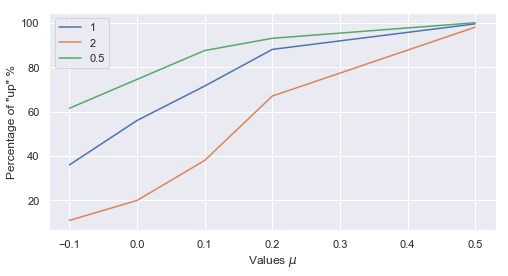

In [5]:
boundary = [1, 2, .5]
plt.figure(figsize=(8,4))
for b in boundary:
    x0 = 0; dt = 0.01
    t = np.arange(0,10,dt) 

    values = [-.1, 0, .1, .2, .5]
    perc = np.zeros(5)

    mu = lambda x0,t,**args: val #deterministic function
    sigma = lambda x0,**args: 0.5 #random function

    for idx,val in enumerate(values):
        for i in range(200): #we want 200 per each value of mu
            decision = euler_maruyama(mu,sigma,x0,t)[0]
            if sum(decision>b)>0: #in case it is higher than the boundary at some point
                perc[idx] += 1
    perc = perc*100/200 #to get a percentage

    

    plt.plot(values, perc)
    plt.xlabel('Values $\mu$');plt.ylabel('Percentage of "up" %');
    plt.legend(boundary)

### Part 3

Use the results from the last exercise to pick a value of $\mu$ (with $\sigma = 0.5$) for which
about $70\%$ of the trials result in an ”up” response. Run 2000 trials and record the
reaction times, i.e. the moment when the decision variable X crosses one of the
two decision thresholds at X = ±a (for a = 1), as well as the choice, i.e. which of
the boundaries was hit.

Considering the results of the previous plot, to evaluate at with a=1, I will choose $\mu$=0.1 to have around 70% trials "up"

In [26]:
x0 = 0; dt = 0.01
t = np.arange(0,10,dt) 
boundary = 1
r_time = np.zeros(2000)

mu = lambda x0,t,**args: .1 #deterministic function
sigma = lambda x0,**args: 0.5 #random function
high = []; low = [];
t_high = []; t_low = [];
for i in range(2000): 
    decision = euler_maruyama(mu,sigma,x0,t)[0]
    if sum(decision>boundary)>0: #in case it is higher than the +boundary
        #high = decision[decision>boundary][0]
        t_ = t[decision>boundary][0]
        t_high.append(t_)
    elif sum(decision<-boundary)>0: #in case it is lower than the -boundary
        #low = decision[decision<-boundary][0]
        t_ = t[decision<-boundary][0]
        t_low.append(t_)
        #This is the way to differentiate whether it hits the positive or negative boundary



### Part 4

Plot a histogram of the reaction times for each of the choices separately, and
compare the distributions. Calculate their individual mean reaction times and
discuss whether (and why) this is what you would have expected.

Can you reproduce qualitatively figure 5b of Gold and Shadlen (2007): increase motion strength (loosely speaking increased drift $\mu$) results in higher percentage correct and reduced mean reaction times?  

3.742262443438914

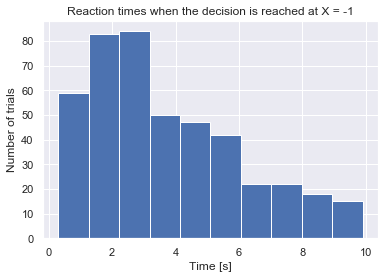

In [43]:
plt.hist(t_low)
plt.title('Reaction times when the decision is reached at X = -1')
plt.xlabel('Time [s]')
plt.ylabel('Number of trials')
np.mean(t_low)

3.8180224403927068

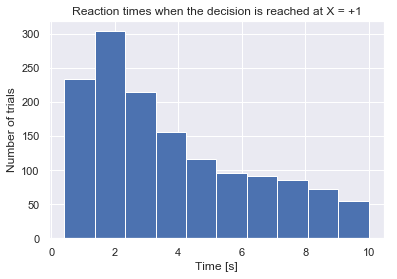

In [44]:
plt.hist(t_high)
plt.title('Reaction times when the decision is reached at X = +1')
plt.xlabel('Time [s]')
plt.ylabel('Number of trials')
np.mean(t_high)

In [8]:
# your code 

In [10]:
# ...

### Part 5

Implement an extended version of the drift-diffusion model, in which the drift $\mu$
for each trial is drawn from a Gaussian distribution with mean $m_{\mu}$ and standard
deviation $s_{\mu}$ . Find values for $m_{\mu}$ and $s_{\mu}$ that keep $70\%$ ”up” rate but have reaction
time distributions that (qualitatively) fit experimental results better. Plot your
resulting distributions and mean reaction times for ”up” and ”down” responses
from 2000 trials.

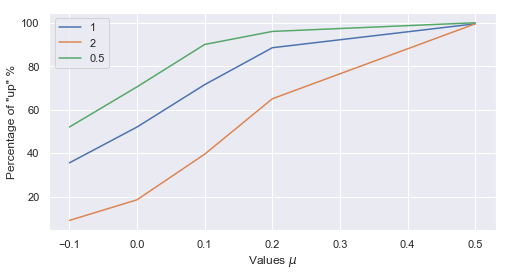